# Rain in Australia

## 1. Problem Definition

Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow

## 2. Data

The data we're using is from Kaggle : https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 3. Evaluation 

Since machine learning is very experimental, you might say something like,

> If we can reach about 85% accuracy at predicting whether or not it will rain tomorrow, we'll pursure this project.

## 4. Features

This dataset contains daily weather observations from numerous Australian weather stations.

The target variable RainTomorrow means: Did it rain the next day? Yes or No.

Note: You should exclude the variable Risk-MM when training a binary classification model. Not excluding it will leak the answers to your model and reduce its predictability. 

### Preparing the tools

* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting of data visualization
* Scikit-Learn for machine learning modelling and evaluation

In [2]:
# Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

### Data Analysis

In [154]:
# load data as data frame
df = pd.read_csv("/content/drive/My Drive/Rain in Australia/weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [144]:
# check info about data frame, like nums of missing values and types of values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

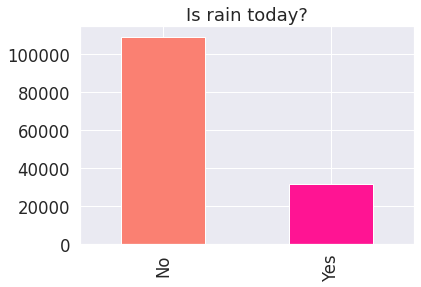

In [145]:
df["RainToday"].value_counts().plot(kind="bar", color=["salmon", "deeppink"]);
plt.title("Is rain today?");

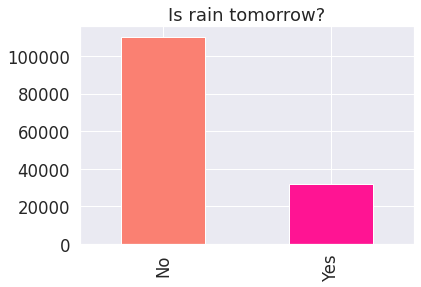

In [146]:
df["RainTomorrow"].value_counts().plot(kind="bar", color=["salmon", "deeppink"]);
plt.title("Is rain tomorrow?");

What is the most minimum and maximim temperature that has ever been recorded?

In [183]:
df_min = df[["Date", "MinTemp"]].sort_values(by="MinTemp")
df_min.head()

,Date,MinTemp
50958,2009-06-11,-8.5
52983,2015-08-04,-8.2
48686,2011-07-29,-8.2
51276,2010-06-29,-8.0
45682,2011-07-29,-8.0


In [185]:
df_max = df[["Date", "MaxTemp"]].sort_values(by="MaxTemp", ascending=False)
df_max.head()

,Date,MaxTemp
103729,2011-01-25,48.1
13601,2014-01-03,47.3
14600,2017-02-12,47.3
29363,2017-02-11,47.0
26415,2017-02-11,46.9


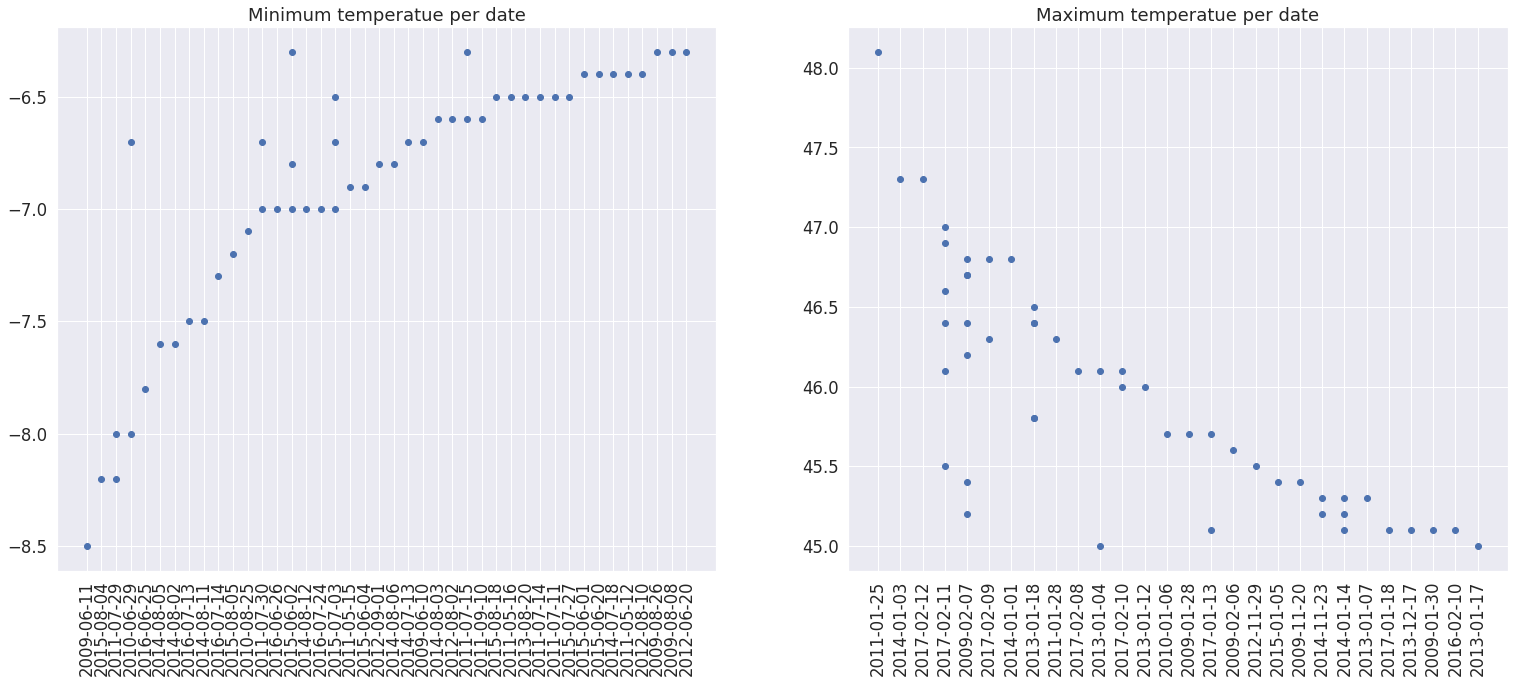

In [204]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 10))
ax[0].scatter(df_min["Date"][:50], df_min["MinTemp"][:50]);
ax[0].set_title("Minimum temperatue per date");
ax[1].scatter(df_max["Date"][:50], df_max["MaxTemp"][:50]);
ax[1].set_title("Maximum temperatue per date");
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90);
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90);

What is the largest amount of rainfall that has ever been recorded.

In [174]:
df_risk_mm = df[["Date", "RISK_MM"]].sort_values(by="RISK_MM", ascending=False)
df_risk_mm.head()

,Date,RISK_MM
9235,2009-11-06,371.0
136880,2011-02-15,367.6
84896,2009-01-11,278.4
85649,2011-02-03,268.6
87021,2015-02-07,247.2


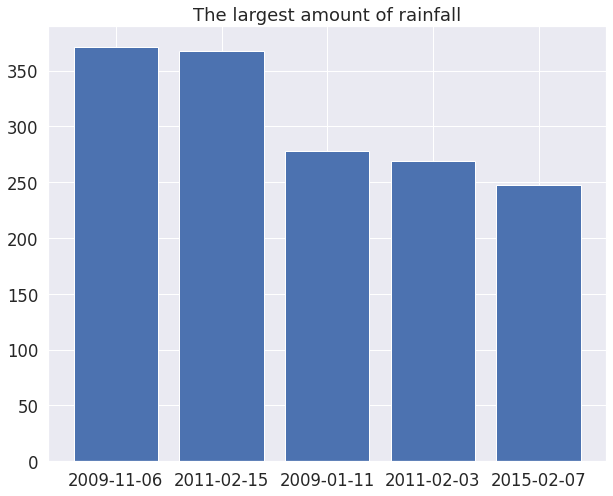

In [181]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(df_risk_mm["Date"][:5], df_risk_mm["RISK_MM"][:5]);
ax.set_title("The largest amount of rainfall");

### Correlation between independent variables

We can do this using df.corr() which will create a correlation matrix for us, in other words, a big table of numbers telling us how related each variable is the other.

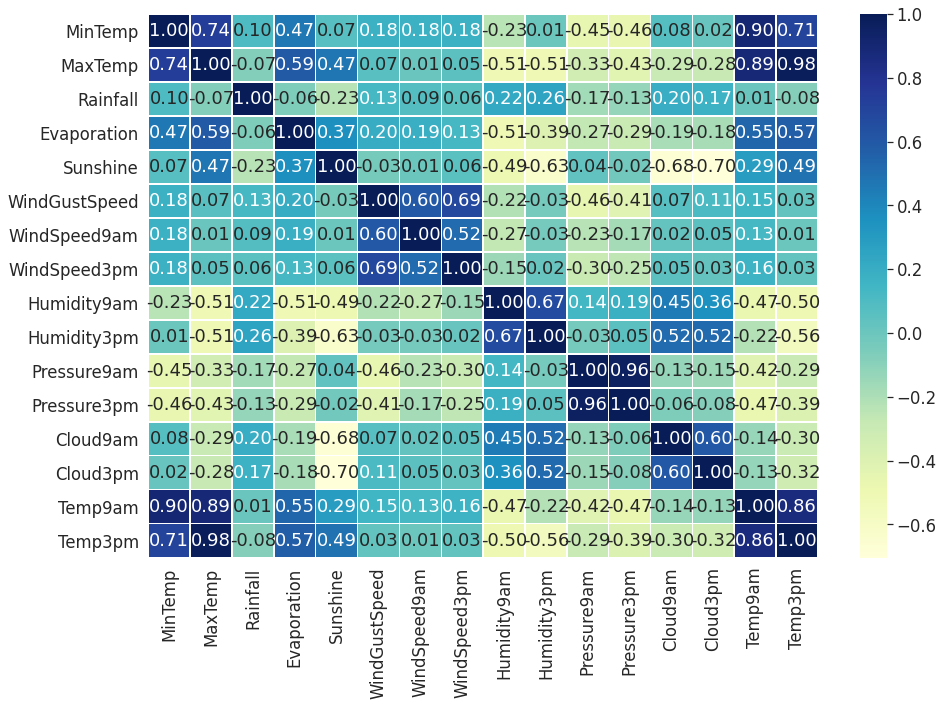

In [153]:
df.drop("RISK_MM", axis=1, inplace=True)

corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

### Parsing dates

We want to prepare our data to make predictions with a machine learning model. So we need:
* date data is the format of a datetime object (a Python data type which encodes specific information about dates)
* convert labels `RainToday` and `RainTomorrow` into a int format
* make sure that all out data in numerical format and it hasn't missing values

**DateTime object**

Let's reload our data frame.

In [83]:
# load data as data frame and date data is a datetime object
df = pd.read_csv("/content/drive/My Drive/Rain in Australia/weatherAUS.csv",
                 parse_dates=["Date"])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [84]:
# now our Date is in a datetime format
df["Date"]

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
142188   2017-06-20
142189   2017-06-21
142190   2017-06-22
142191   2017-06-23
142192   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

**Sort Data Frame by Date**

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [85]:
df.sort_values(by="Date", ascending=True, inplace=True)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
44351,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,3.6,Yes
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,3.6,Yes
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,39.8,Yes
44354,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,2.8,Yes
44355,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,0.0,No


We can access the different datetime attributes of the Date column because all our Date in a datetime format.

In [86]:
# add datetime parameters for date
df["DateYear"] = df["Date"].dt.year
df["DateMonth"] = df["Date"].dt.month
df["DateDay"] = df["Date"].dt.day
df["DateDayofweek"] = df["Date"].dt.dayofweek
df["DateDayofyear"] = df["Date"].dt.dayofyear

# now we don't need a Date column, so we can drop it
df.drop("Date", axis=1, inplace=True)
# exclude the variable Risk-MM
df.drop("RISK_MM", axis=1, inplace=True)

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,DateYear,DateMonth,DateDay,DateDayofweek,DateDayofyear
44351,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,2007,11,1,3,305
44352,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,2007,11,2,4,306
44353,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2007,11,3,5,307
44354,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,2007,11,4,6,308
44355,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,2007,11,5,0,309


**Convert predictions columns to a int format**

To make predictions with a machine learning we need all columns in a numerical format, so we should convert:
* YES as 1
* NO as 0

Before we make it, let's drop all missing values in columns `RainToday` and `RainTomorrow`, because we want to predict them.

In [87]:
# drop missing values in RainToday column if exists
if df["RainToday"].isna().sum():
  df = df.dropna(subset=["RainToday"])

In [88]:
# drop missing values in RainTomorrow column if exists
if df["RainTomorrow"].isna().sum():
  df = df.dropna(subset=["RainTomorrow"])

In [89]:
# check if in columns RainToday and RainTomorrow missing values
print(f"Number of missing values in column RainToday = {df.RainToday.isna().sum()}")
print(f"Number of missing values in column RainTomorrow = {df.RainTomorrow.isna().sum()}")

Number of missing values in column RainToday = 0
Number of missing values in column RainTomorrow = 0


In [90]:
# function to convert into int format
def convert_int_from_yes_or_no(df, label):
  """
  To convert source label from "Yes" or "No" values
  to int format as 1 or 0.
  df : source data frame
  label : column's name to convert
  """
  df[label] = df[label].str.replace("Yes", "1")
  df[label] = df[label].str.replace("No", "0")
  df[label] = df[label].astype(int)

# convert columns
convert_int_from_yes_or_no(df, "RainToday")
convert_int_from_yes_or_no(df, "RainTomorrow")
df[["RainToday", "RainTomorrow"]]

,RainToday,RainTomorrow
44351,0,1
44352,1,1
44353,1,1
44354,1,1
44355,1,0
...,...,...
38814,0,0
32833,0,0
29496,0,0
26545,0,0


**Convert strings to categories**

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

In [91]:
# turn all of the string values into category values
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 44351 to 35838
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Location       140787 non-null  category
 1   MinTemp        140319 non-null  float64 
 2   MaxTemp        140480 non-null  float64 
 3   Rainfall       140787 non-null  float64 
 4   Evaporation    81093 non-null   float64 
 5   Sunshine       73982 non-null   float64 
 6   WindGustDir    131624 non-null  category
 7   WindGustSpeed  131682 non-null  float64 
 8   WindDir9am     131127 non-null  category
 9   WindDir3pm     137117 non-null  category
 10  WindSpeed9am   139732 non-null  float64 
 11  WindSpeed3pm   138256 non-null  float64 
 12  Humidity9am    139270 non-null  float64 
 13  Humidity3pm    137286 non-null  float64 
 14  Pressure9am    127044 non-null  float64 
 15  Pressure3pm    127018 non-null  float64 
 16  Cloud9am       88162 non-null   float64 
 17  Cloud3p

In [92]:
# check missing values
df.isna().sum()

Location             0
MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustDir       9163
WindGustSpeed     9105
WindDir9am        9660
WindDir3pm        3670
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
RainToday            0
RainTomorrow         0
DateYear             0
DateMonth            0
DateDay              0
DateDayofweek        0
DateDayofyear        0
dtype: int64

**Fill numerical missing values**

Let's fine numerical missing values and fill them as median.

In [93]:
# find all numerical missinf values
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        # fill them
        df[label] = content.fillna(content.median())

# checking
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if df[label].isna().sum():
          print(label)

**Fill categorical missing values**

Let's fine categorical missing values and fill them as encodes. 

In [94]:
# find all categorical missinf values
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add the +1 because pandas encodes missing categories as -1
        df[label] = pd.Categorical(content).codes+1

# checking
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if df[label].isna().sum():
          print(label)

In [95]:
# check missing values
df.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
DateYear         0
DateMonth        0
DateDay          0
DateDayofweek    0
DateDayofyear    0
dtype: int64

Now all our data frame is in numerical format and it hasn't missing values, so we can start make predictions.

## 5. Modelling

We'll be using the following models and comparing their results.

1. LogisticRegression
2. KNeighborsClassifier
3. RandomForestClassifier
4. GaussianNB

In [96]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,DateYear,DateMonth,DateDay,DateDayofweek,DateDayofyear
44351,10,8.0,24.3,0.0,3.4,6.3,8,30.0,13,8,6.0,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,0,1,2007,11,1,3,305
44352,10,14.0,26.9,3.6,4.4,9.7,2,39.0,1,14,4.0,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,1,1,2007,11,2,4,306
44353,10,13.7,23.4,3.6,5.8,3.3,8,85.0,4,6,6.0,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,1,1,2007,11,3,5,307
44354,10,13.3,15.5,39.8,7.2,9.1,8,54.0,15,14,30.0,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,1,1,2007,11,4,6,308
44355,10,7.6,16.1,2.8,5.6,10.6,11,50.0,11,3,20.0,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,1,0,2007,11,5,0,309


Split our data on

* training set (about 80%)
* test set (about 20%)

In [97]:
# everything except target variable
X = df.drop(["RainTomorrow"], axis=1)
# target variable
y = df["RainTomorrow"]

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let's create a function to train our models and make scores.

In [98]:
# put models into a dictionary
models = {"LogisticRegression" : LogisticRegression(),
          "KNeighborsClassifier" : KNeighborsClassifier(),
          "RandomForestClassifier" : RandomForestClassifier(), 
          "GaussianNB" : GaussianNB()}

# create a function to fit model and make scores
def fit_and_score(models, X_train, X_test, y_train, y_test):
  """
  Fits and evaluates given machine learning models.
  models : a dict of different Scikit-Learn machine learning models
  X_train : training data
  X_test : testing data
  y_train : labels assosciated with training data
  y_test : labels assosciated with test data
  """
  # random seed for reproducible results
  np.random.seed(42)
  # make a list to keep model scores
  model_scores = {}
  # loop through models
  for name, model in models.items():
    # fit the model to the data
      model.fit(X_train, y_train)
      # evaluate the model and append its score to model_scores
      model_scores[name] = model.score(X_test, y_test)
  return model_scores  

In [99]:
# check results
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'GaussianNB': 0.8062717522551317,
 'KNeighborsClassifier': 0.8435258185950707,
 'LogisticRegression': 0.8427800269905533,
 'RandomForestClassifier': 0.8600752894381704}

**Compare models by accuracy**

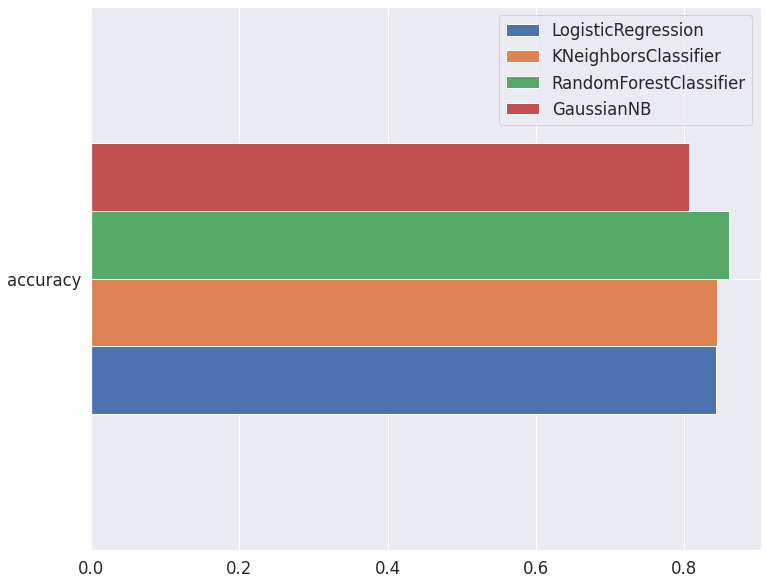

In [106]:
pd.DataFrame(model_scores, index=["accuracy"]).plot.barh(figsize=(12, 10));


So, let's pick the worst model and try to tune hyperparameters for it.

**Tune KNeighborsClassifier with GridSearchCV**

Try to pick parameters by incomplete dataset.

In [107]:
# different KNeighborsClassifier hyperparameters
param_grid = dict(n_neighbors = np.arange(5,10), weights = ["uniform", "distance"],
                  metric=['minkowski','euclidean','manhattan'])

# setup grid hyperparameter search for KNeighborsClassifier
knn_model = GridSearchCV(KNeighborsClassifier(),
                          param_grid=param_grid,
                          cv=5,
                          verbose=True,
                         n_jobs=-1)

# fit grid hyperparameter search model
knn_model.fit(X_train[:20000], y_train[:20000]);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


In [108]:
# check best parameters
knn_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

In [111]:
# evaluate model
acc_before = model_scores["KNeighborsClassifier"]
print(f"Before tuning score = {acc_before}")
print(f"After tuning score = {knn_model.score(X_test, y_test)}")

Before tuning score = 0.8435258185950707
After tuning score = 0.8413949854393068


So, we draw a conclusion, that KNeighborsClassifier is incorrect model.

**Tune GaussianNB with RandomizedSearchCV**

Try to pick parameters by incomplete dataset.

In [112]:
# setup random seed
np.random.seed(42)

# different GaussianNB hyperparameters
param_grid = dict(priors = [None], var_smoothing = [0.00000001, 0.000000001, 0.0000000001, 
                                                    0.00000000001, 0.000000000001, 0.0000000000001])

# setup random hyperparameter search for GaussianNB
gaus_model = RandomizedSearchCV(GaussianNB(),
                                param_distributions=param_grid,
                                cv=5,
                                n_iter=5,
                                verbose=True, 
                               n_jobs=-1)

# fit random hyperparameter search model
gaus_model.fit(X_train[:20000], y_train[:20000]);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished


In [113]:
# check best parameters
gaus_model.best_params_

{'priors': None, 'var_smoothing': 1e-08}

In [114]:
# evaluate model
acc_before = model_scores["GaussianNB"]
print(f"Before tuning score = {acc_before}")
print(f"After tuning score = {gaus_model.score(X_test, y_test)}")

Before tuning score = 0.8062717522551317
After tuning score = 0.8038212941260032


So, we draw a conclusion, that GaussianNB is incorrect model.

**Tune LogisticRegression with GridSearchCV**

Try to pick parameters by incomplete dataset.

In [115]:
# different LogisticRegression hyperparameters
param_grid = dict(penalty = ['l2', 'elasticnet'], C = np.logspace(-4, 4, 20),
                  solver = ["liblinear", "saga", "newton-cg"])

# setup grid hyperparameter search for LogisticRegression
log_reg_model = GridSearchCV(LogisticRegression(max_iter=500),
                          param_grid=param_grid,
                          cv=5,
                          verbose=True,
                         n_jobs=-1)

# fit grid hyperparameter search model
log_reg_model.fit(X_train[:10000], y_train[:10000]);

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.2min finished
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/o

In [116]:
# check best parameters
log_reg_model.best_params_

{'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'newton-cg'}

In [117]:
# evaluate model
acc_before = model_scores["LogisticRegression"]
print(f"Before tuning score = {acc_before}")
print(f"After tuning score = {log_reg_model.score(X_test, y_test)}")

Before tuning score = 0.8427800269905533
After tuning score = 0.8449463740322466


**Tune RandomForestClassifier with RandomizedSearchCV**

Try to pick parameters by incomplete dataset.

In [128]:
# different RandomForestClassifier hyperparameters
param_grid = dict(n_estimators = np.arange(10, 500, 10), max_depth = [None, 3, 5, 10],
                  min_samples_split = np.arange(2, 20, 2), min_samples_leaf = np.arange(1, 20, 2))

# setup grid hyperparameter search for RandomForestClassifier
rf_model = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=param_grid,
                          cv=5,
                          verbose=True,
                          n_iter=20,
                         n_jobs=-1)

# fit grid hyperparameter search model
rf_model.fit(X_train[:5000], y_train[:5000]);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


In [129]:
# check best parameters
rf_model.best_params_

{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 160}

In [130]:
# evaluate model
acc_before = model_scores["RandomForestClassifier"]
print(f"Before tuning score = {acc_before}")
print(f"After tuning score = {rf_model.score(X_test, y_test)}")

Before tuning score = 0.8600752894381704
After tuning score = 0.8452304851196818


So, we draw a conclusion, that RandomForestClassifier is incorrect model.

## 6. Evaluating a classification model, beyond accuracy

We want:

* ROC curve and AUC score - plot_roc_curve()
* Confusion matrix - confusion_matrix()
* Classification report - classification_report()
* Precision - precision_score()
* Recall - recall_score()
* F1-score - f1_score()

### ROC curve

comparing the true positive rate to the false positive rate.

> To get an appropriate example in a real-world problem, consider a diagnostic test that seeks to determine whether whether or not it will rain tomorrow. A false positive in this case occurs when the will rain tomorrow, but it does not actually. A false negative, on the other hand, occurs when the will not rain tomorrow,  when it actually do.

Scikit-Learn implements a function plot_roc_curve which can help us create a ROC curve as well as calculate the area under the curve (AUC) metric.

In [131]:
# make preidctions on test data
y_preds = log_reg_model.predict(X_test)

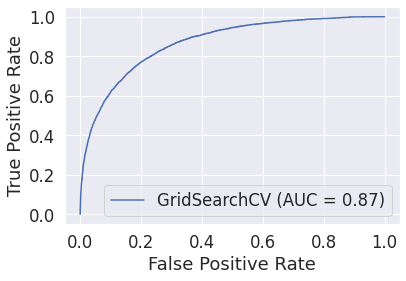

In [132]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(log_reg_model, X_test, y_test);

### Confusion matrix

A confusion matrix is a visual way to show where your model made the right predictions and where it made the wrong predictions (or in other words, got confused).

Scikit-Learn allows us to create a confusion matrix using confusion_matrix() and passing it the true labels and predicted labels.

In [133]:
# display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[20626  1237]
 [ 3129  3166]]


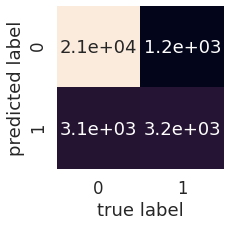

In [134]:
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

### Classification report

We can make a classification report using classification_report() and passing it the true labels as well as our models predicted labels.

A classification report will also give us information of the precision and recall of our model for each class.

In [135]:
# show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21863
           1       0.72      0.50      0.59      6295

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.75     28158
weighted avg       0.83      0.84      0.83     28158



### Other metrics

* Precision - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.
* Recall - Indicates the proportion of actual positives which were correctly classified. A model which produces no false negatives has a recall of 1.0.
* F1 score - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.
* Support - The number of samples each metric was calculated on.
* Accuracy - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0.

Let's make an evaluation function.

In [136]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [137]:
# make preidctions on test data
y_preds_knn = knn_model.predict(X_test)
y_preds_gaus = gaus_model.predict(X_test)
y_preds_lr = log_reg_model.predict(X_test)
y_preds_rf = rf_model.predict(X_test)

# evaluate the predictions
print("KNeighborsClassifier")
knn_metrics = evaluate_preds(y_test, y_preds_knn)
print("GaussianNB")
gaus_metrics = evaluate_preds(y_test, y_preds_gaus)
print("LogisticRegression")
lr_metrics = evaluate_preds(y_test, y_preds_lr)
print("RandomForestClassifier")
rf_metrics = evaluate_preds(y_test, y_preds_rf)

KNeighborsClassifier
Accuracy: 84.14%
Precision: 0.75
Recall: 0.44
F1 score: 0.55
GaussianNB
Accuracy: 80.38%
Precision: 0.55
Recall: 0.62
F1 score: 0.59
LogisticRegression
Accuracy: 84.49%
Precision: 0.72
Recall: 0.50
F1 score: 0.59
RandomForestClassifier
Accuracy: 84.52%
Precision: 0.74
Recall: 0.48
F1 score: 0.58


Let's create a DataFrame to compare the different metrics.

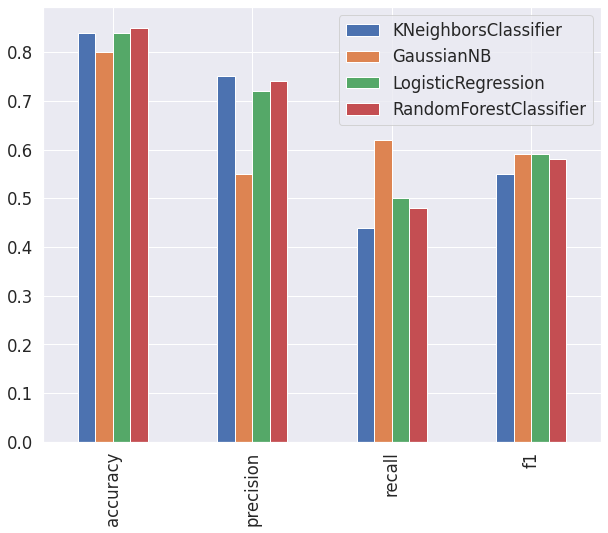

In [138]:
compare_metrics = pd.DataFrame({"KNeighborsClassifier": knn_metrics,
                                "GaussianNB": gaus_metrics,
                                "LogisticRegression": lr_metrics,
                                "RandomForestClassifier": rf_metrics})
compare_metrics.plot.bar(figsize=(10, 8));

## Feature importance

Feature importance is another way of asking, "which features contributing most to the outcomes of the model?"

Since we're using LogisticRegression, we'll look at one way we can calculate feature importance for it.

To do so, we'll use the coef_ attribute. Looking at the Scikit-Learn documentation for LogisticRegression, the coef_ attribute is the coefficient of the features in the decision function.

We can access the coef_ attribute after we've fit an instance of LogisticRegression.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

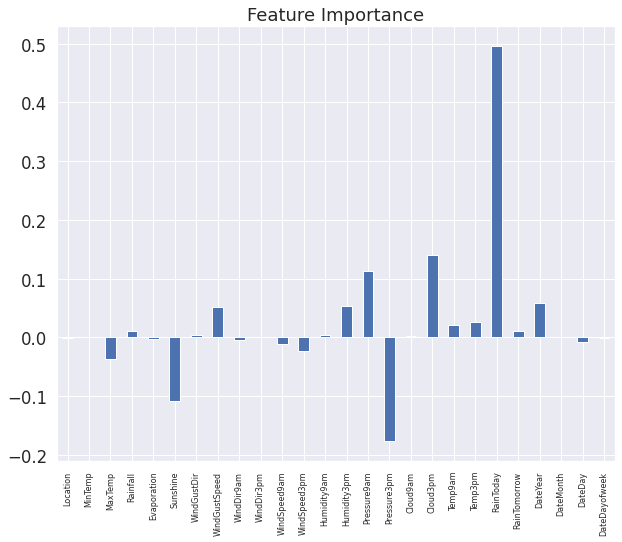

In [142]:
# instantiate best model with best hyperparameters (found with GridSearchCV)
clf = LogisticRegression(C=0.004832930238571752, penalty='l2', solver='newton-cg')
clf.fit(X_train, y_train);

# check coef_
clf.coef_

# match features to columns
features_dict = dict(zip(df.columns, list(clf.coef_[0])))

# visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(10, 8));
plt.xticks(size=8);

You'll notice some are negative and some are positive.

The larger the value (bigger bar), the more the feature contributes to the models decision.

If the value is negative, it means there's a negative correlation. And vice versa for positive values.

## Vizualize results

Create a data frame which contains test data and results is rain tomorrow (actual and predicted).

In [141]:
df_res = pd.DataFrame(X_test[["DateYear", "DateMonth", "DateDay"]])
df_res["IsRainTomorrow_predicted"] = y_preds_rf.astype(str)
df_res["IsRainTomorrow_predicted"] = df_res["IsRainTomorrow_predicted"].replace("1", "Yes")
df_res["IsRainTomorrow_predicted"] = df_res["IsRainTomorrow_predicted"].replace("0", "No")
df_res["IsRainTomorrow_actual"] = y_test.astype(str)
df_res["IsRainTomorrow_actual"] = df_res["IsRainTomorrow_actual"].replace("1", "Yes")
df_res["IsRainTomorrow_actual"] = df_res["IsRainTomorrow_actual"].replace("0", "No")
df_res["Date"] = df_res["DateYear"].astype(str) + "-" + df_res["DateMonth"].astype(str)  + "-" +  df_res["DateDay"].astype(str)
df_res.drop(["DateYear", "DateMonth", "DateDay"], axis=1, inplace=True)
df_res = df_res.reset_index()
df_res.drop("index", axis=1, inplace=True)
df_res["Date"] = pd.to_datetime(df_res["Date"])
df_res

,IsRainTomorrow_predicted,IsRainTomorrow_actual,Date
0,No,No,2011-06-09
1,No,No,2014-06-21
2,No,No,2014-01-15
3,No,No,2012-11-12
4,No,Yes,2010-01-29
...,...,...,...
28153,No,No,2012-02-15
28154,No,No,2013-09-12
28155,No,No,2015-06-07
28156,No,No,2010-08-24
